# Unconfined Transient Flow Model

The following example was taken from the online flopy documentation (tutorial #2 for MODFLOW).  We added some additional information to clarify the steps.  In this example, we will convert the tutorial 1 model into an unconfined, transient flow model with time varying boundaries. Instead of using constant heads for the left and right boundaries (by setting ibound to -1), we will use general head boundaries. We will have the model consider the following conditions:

    - Initial conditions – head is 10.0 everywhere

    - Period 1 (1 day) – steady state with left and right GHB stage = 10.

    - Period 2 (100 days) – left GHB with stage = 10., right GHB with stage set to 0.

    - Period 3 (100 days) – pumping well at model center with rate = -500., left and right GHB = 10., and 0.


## Start with Imports

In [1]:
import os
import numpy as np
import flopy

## Set the Working Directory
The current working directory (a Windows thing) is by default the directory where you launched jupyter lab.  If you do this from the Start menu instead of the anaconda prompt, then that is almost always c:\users\yourname if you are using windows.

In [2]:
cwd = os.getcwd()                           # return the name of the current working directory
print(cwd)
workingdir = os.path.join(cwd,'model')      # define where we want to run the model.
# we used the os.path.join command because it is operating system agnostic
# we could just as easily used workdir = cwd + '/model'
print(workingdir)
# the following command checks to see if that directory exists
# if it does not exist, then it will create that directory
if not os.path.exists(workingdir):
    os.makedirs(workingdir)

C:\repos\private\corso-flopy\materials\Session5
C:\repos\private\corso-flopy\materials\Session5\model


## Creating the MODFLOW Model
Define the Model Extent, Grid Resolution, and Characteristics

Assign the model information

In [3]:
Lx = 1000.0
Ly = 1000.0
ztop = 10.0
zbot = -50.0
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)
hk = 1.0
vka = 1.0
sy = 0.1
ss = 1.0e-4
laytyp = 1

## BASIC Package
The basic package contains an integer array of -1, 0, and 1 for constant heads, inactive cells, and active cells, respectively.  It also contains the starting heads for the model.  We set up these arrays here.  The call to np.ones sets all cells to a value of 1 (active) and starting heads to 10 ft above sea level.

In [4]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)

## Define the Stress Periods

To create a model with multiple stress periods, we need to define the number of stress periods (nper), length of each stress period (perlen), number of timesteps for each period (nstp), and whether the period is steadystate or transient. This is done in the following block in a manner that allows us to pass these variable directly to the discretization object:

In [5]:
nper = 3
perlen = [1, 100, 100]
nstp = [1, 100, 100]
steady = [True, False, False]

## Create Time-Invariant Flopy Objects

With this information, we can now create the static flopy objects that do not change with time:

In [6]:
modelname = "transient_model"
ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name="mf2005", model_ws=workingdir)
#
# set up the discretization package
#
dis = flopy.modflow.ModflowDis(
    ml,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm[1:],
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=steady,
)
#
# set up the BASIC Package
#
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)
#
# set up LPF (layer property flow) Package 
# note: vka is vertical anisotropy and not kz.  vka = kx/kz
#       laytyp is either 1 (unconfined) or 0 (confined) for each layer (1d array)
#       ipakcb is the fortran unit number for the cell-by-cell flows
#
lpf = flopy.modflow.ModflowLpf(ml, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
#
# pcg is the solver called pcg2 in modflow2005
# note: mxiter is number of outer iterations, iter1 is number of inner iterations, hclose is the head change criterion
#       other pcg parameters use the flopy defaults
#       to see what these defaults are, type help(flopy.modflow.ModflowPcg) in separate cell or uncomment the command below.
#
pcg = flopy.modflow.ModflowPcg(ml,mxiter=50,iter1=30,hclose=1.0e-3)
#help(flopy.modflow.ModflowPcg)

## Transient General-Head Boundary Package

At this point, our model is ready to add our transient boundary packages. First, we will create the GHB object, which is of the following type: flopy.modflow.ModflowGhb().

The key to creating Flopy transient boundary packages is recognizing that the boundary data is stored in a dictionary with key values equal to the zero-based stress period number and values equal to the boundary conditions for that stress period. For a GHB the values can be a two-dimensional nested list of [layer, row, column, head, conductance].  Note that layer, row, and column are also zero-based so the first layer is 0, etc.

In [7]:
stageleft = 10.0
stageright = 10.0
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp1), "GHBs for stress period 1.")

Adding  20 GHBs for stress period 1.


In [8]:
# Make list for stress period 2
stageleft = 10.0
stageright = 0.0
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp2), "GHBs for stress period 2.")

Adding  20 GHBs for stress period 2.


In [9]:
# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation
#
# stress_period_data is a dictionary
#     the 0: and 1: values are the stress periods (zero-based)
#     the arrays after the stress period numbers are the ghb data we created above
#
stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [10]:
# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=stress_period_data)

## Transient Well Package

Now we can create the well package.  In the example below we are putting one well at the center of the grid, which is why we are computing the row and column number instead of just plugging it in directly.  By doing it this way, you can test the effect of grid resolution by adjusting the number of row and columns above and the well will always be at the center of the mesh.

In [11]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -500.0
wel_sp1 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]
wel_sp2 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]
wel_sp3 = [[0, nrow / 2 - 1, ncol / 2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(ml, stress_period_data=stress_period_data)

## Output Control

Here we create the output control package.  We start by creating a dictionary of data for each time step.  This dictionary is more complicated than for the well and ghb above.  In wells and ghbs, the disctionary is the stress period number (zero based) followed by a colon (:) and then the data for the well or ghb.  In output control, the dictionary key is a tuple - two numbers in parentheses separated by a comma.  So (0,0) is stress period 1, time step 1.  Uncomment the print statement to see the disctionary entriess.

In [12]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]
#print(stress_period_data)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=stress_period_data, compact=True)

## Running the Model

Run the model with the run_model method, which returns a success flag and the stream of output. With run_model, we have some finer control, that allows us to suppress the output.

In [13]:
# Write the model input files
ml.write_input()

In [14]:
# Run the model
success, mfoutput = ml.run_model(silent=True, pause=False)
if not success:
    raise Exception("MODFLOW did not terminate normally.")
else:
    print("MODFLOW ran successfully")

MODFLOW ran successfully


## Post-processing Results

We will now read heads from the MODFLOW binary output file using the flopy.utils.binaryfile() module. Included with the HeadFile object are several methods that we will use here:

    get_times() will return a list of times contained in the binary head file

    get_data() will return a three-dimensional head array for the specified time

    get_ts() will return a time series array [ntimes, headval] for the specified cell

Using these methods, we can create head plots and hydrographs from the model results.

In [15]:
# Imports
import matplotlib.pyplot as plt

In [16]:
import flopy.utils.binaryfile as bf

In [17]:
# Create the headfile and budget file objects
headfile = os.path.join(workingdir,modelname+'.hds')
headobj = bf.HeadFile(headfile)
times = headobj.get_times()
#
cbbname = os.path.join(workingdir,modelname+'.cbc')
cbb = bf.CellBudgetFile(cbbname)

## Set up Parameters for Contouring

In [18]:
# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr / 2.0, Lx - delr / 2.0, delc / 2.0, Ly - delc / 2.0)
print("Levels: ", levels)
print("Extent: ", extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [19]:
# Well point for plotting
wpt = (450.0, 550.0)

## Create Contour Maps


*****Processing time:  1.0
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0
*****Processing time:  101.0
Head statistics
  min:  0.025917815
  max:  9.99843
  std:  3.2573593
*****Processing time:  201.0
Head statistics
  min:  0.016293392
  max:  9.994032
  std:  3.1543627


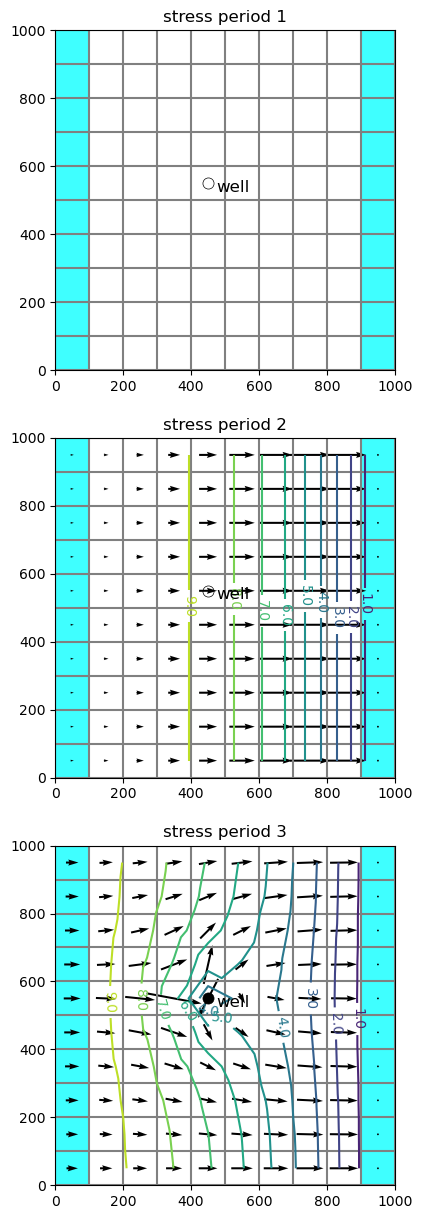

In [20]:
# Make the plots
fig = plt.figure(figsize=(5, 15))
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print("*****Processing time: ", time)
    head = headobj.get_data(totim=time)
    # Print statistics
    print("Head statistics")
    print("  min: ", head.min())
    print("  max: ", head.max())
    print("  std: ", head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text="FLOW RIGHT FACE", totim=time)[0]
    fff = cbb.get_data(text="FLOW FRONT FACE", totim=time)[0]

    # Create a map for this time
    ax = fig.add_subplot(len(mytimes), 1, iplot + 1, aspect="equal")
    ax.set_title(f"stress period {iplot + 1}")

    pmv = flopy.plot.PlotMapView(model=ml, layer=0, ax=ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid()
    qm = pmv.plot_bc("GHB", alpha=0.5)
    if head.min() != head.max():
        cs = pmv.contour_array(head, levels=levels)
        plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
        quiver = pmv.plot_vector(frf, fff)

    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(
        wpt[0],
        wpt[1],
        lw=0,
        marker="o",
        markersize=8,
        markeredgewidth=0.5,
        markeredgecolor="black",
        markerfacecolor=mfc,
        zorder=9,
    )
    ax.text(wpt[0] + 25, wpt[1] - 25, "well", size=12, zorder=12)

## Plot the Well Hydrograph

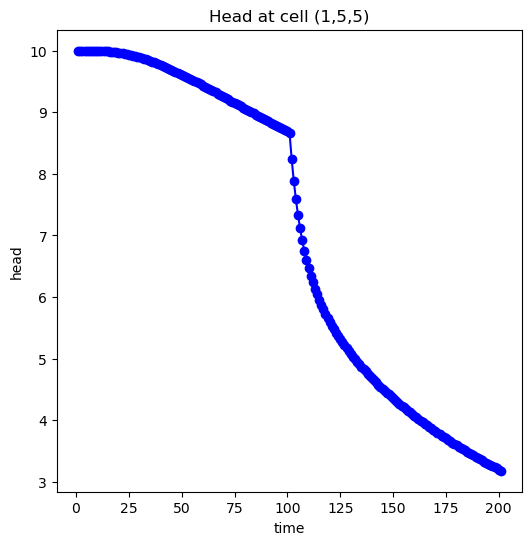

In [21]:
# Plot the head versus time
idx = (0, int(nrow / 2) - 1, int(ncol / 2) - 1)
ts = headobj.get_ts(idx)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ttl = f"Head at cell ({idx[0] + 1},{idx[1] + 1},{idx[2] + 1})"
ax.set_title(ttl)
ax.set_xlabel("time")
ax.set_ylabel("head")
ax.plot(ts[:, 0], ts[:, 1], "bo-")